In [1]:
# 투수 EDA

%run ../data_tools.ipynb
%run ../create_metrics.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import xgboost
import shap

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from plotly.offline import plot
from plotly.offline import init_notebook_mode

init_notebook_mode(connected = True)


C:\Users\jmp08\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
crawled_player_batter = pd.read_csv("../Crawler/crawled_player_batter.csv")
crawled_player_pitcher = pd.read_csv("../Crawler/crawled_player_pitcher.csv")
crawled_team_batter = pd.read_csv("../Crawler/crawled_team_batter.csv")
crawled_team_pitcher = pd.read_csv("../Crawler/crawled_team_pitcher.csv")
crawled_csum_player_pitcher = pd.read_csv("../Crawler/crawled_csum_player_pitcher.csv")

crawled_player_batter = crawled_player_batter.drop(["TB"], axis = "columns")
crawled_team_batter = crawled_team_batter.drop(["TB", "START_CK"], axis = "columns")
crawled_player_pitcher = crawled_player_pitcher.drop(["WHIP"], axis = "columns")
crawled_team_pitcher = crawled_team_pitcher.drop(["WHIP"], axis = "columns")
crawled_csum_player_pitcher = crawled_csum_player_pitcher.drop(["WHIP", "MONEY", "AGE_VA", "NAME"], axis = "columns")

In [4]:
total_data = []
for i in list(range(2016, 2021)) :
    rawData = load_data(i)
    Scaling_Money(rawData["player"])
    rawData["player_batter"] = pd.merge(rawData["player_batter"], rawData["player"][["P_ID", "T_ID", "AGE_VA", "MONEY", "NAME"]])
    rawData["player_pitcher"] = pd.merge(rawData["player_pitcher"], rawData["player"][["P_ID", "T_ID", "AGE_VA", "MONEY", "NAME"]])
    
    rawData["player_batter"] = rawData["player_batter"][crawled_player_batter.columns]
    rawData["player_pitcher"] = rawData["player_pitcher"][crawled_player_pitcher.columns]
    rawData["team_batter"] = rawData["team_batter"][crawled_team_batter.columns]
    rawData["team_pitcher"] = rawData["team_pitcher"][crawled_team_pitcher.columns]
    rawData["csum_player_pitcher"] = rawData["csum_player_pitcher"][crawled_csum_player_pitcher.columns]
    
    if i == 2020 :
        rawData["player_batter"] = pd.concat([rawData["player_batter"], crawled_player_batter]).reset_index(drop = True)
        rawData["player_pitcher"] = pd.concat([rawData["player_pitcher"], crawled_player_pitcher]).reset_index(drop = True)
        rawData["team_batter"] = pd.concat([rawData["team_batter"], crawled_team_batter]).reset_index(drop = True)
        rawData["team_pitcher"] = pd.concat([rawData["team_pitcher"], crawled_team_pitcher]).reset_index(drop = True)
        rawData["csum_player_pitcher"] = pd.concat([rawData["csum_player_pitcher"], crawled_csum_player_pitcher]).reset_index(drop = True)
        
    make_batter_metrics(rawData, "player_batter")
    make_batter_metrics(rawData, "team_batter")
    make_pitcher_metrics(rawData, "player_pitcher")
    make_pitcher_metrics(rawData, "team_pitcher")
    total_data.append(rawData)

tableList = []
for key in total_data[0].keys() :
    tableList.append(key)

final_data = dict()
for key in tableList :
    final_data[key] = pd.DataFrame()

for year in range(len(total_data)) :
    for key in tableList :
        if final_data[key].empty :
            final_data[key] = total_data[year][key]
        else :
            final_data[key] = pd.concat([final_data[key], total_data[year][key]], axis = 0)
            
for key in final_data.keys() :
    final_data[key].reset_index(drop = True)

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning:

In [5]:
# 세이버 메트릭스 대부분의 지표는 선수 개인을 대상으로 합니다.
# 예측은 팀 단위로 이루어지기 때문에 선수 데이터를 바탕으로 팀을 대표할 수 있도록
# 각 선수의 세이버 메트릭스 지표에 대해 타자의 경우 타석 수, 투수의 경우 이닝 수를 기준으로
# 경기 별 각 선수의 가중 평균을 해당 경기의 팀 스탯으로 나타냈습니다.

final_data["player_pitcher"].rename(columns = {"MONEY" : "MONEY_PIT", "AGE_VA" : "AGE_VA_PIT"}, inplace = True)
final_data["player_pitcher"] = final_data["player_pitcher"].reset_index(drop = True)

metrics_pitcher = ["BB/9", "LOB%", "FIP", "DER", "ERC", "ERA", "WHIP", "RA/9", "MONEY_PIT", "AGE_VA_PIT"]
final_data["player_pitcher"].sort_values(by = ["T_ID", "GDAY_DS", "HEADER_NO"])
final_data["player_pitcher"] = final_data["player_pitcher"].reset_index(drop = True)

result = final_data["player_pitcher"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"])["INN2"].sum()
result = result.to_frame().dropna().reset_index()
result.rename(columns = {"INN2" : "INN2_SUM"}, inplace = True)
result

final_data["team_pitcher"] = pd.get_dummies(final_data["team_pitcher"], columns = ["WLS"], drop_first = True)

final_data["player_pitcher"] = pd.merge(final_data["player_pitcher"], result)
final_data["player_pitcher"][metrics_pitcher] = final_data["player_pitcher"][metrics_pitcher].mul((final_data["player_pitcher"]["INN2"] / final_data["player_pitcher"]["INN2_SUM"]), axis = 0)
final_data["player_pitcher"] = final_data["player_pitcher"].drop("INN2_SUM", axis = "columns")
final_data["player_pitcher"] = final_data["player_pitcher"][final_data["player_pitcher"]["INN2"] != 0]
final_data["player_pitcher"] = final_data["player_pitcher"][~np.isinf(final_data["player_pitcher"]["LOB%"])]
final_data["player_pitcher"]

,GDAY_DS,START_CK,INN2,R,ER,PA,AB,HIT,H2,H3,...,K/9,BB/9,LOB%,FIP,WHIP,RA/9,DER,ERC,ERA,PPF
0,20160401,0,6.0,0.0,0.0,8.0,7.0,1.0,0.0,0.0,...,1.500000,0.083333,0.166667,-0.202297,0.166667,0.000000,0.125000,-0.006595,0.000000,NaN
1,20160401,0,5.0,0.0,0.0,8.0,6.0,2.0,0.0,0.0,...,0.600000,0.083333,0.138889,0.123086,0.250000,0.000000,0.092593,0.112715,0.000000,0.876596
2,20160401,0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,...,0.000000,0.000000,0.027778,0.010982,0.083333,0.000000,0.013889,0.104118,0.000000,0.906066
3,20160401,1,18.0,4.0,4.0,28.0,25.0,9.0,2.0,0.0,...,0.666667,0.083333,0.300000,-0.218992,0.833333,0.333333,0.304348,0.566746,0.333333,0.882331
4,20160401,0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,...,1.000000,0.000000,NaN,-0.145229,0.000000,0.000000,0.083333,-0.046667,0.000000,0.769309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30030,20200916,0,9.0,0.0,0.0,11.0,10.0,1.0,0.0,0.0,...,1.000000,0.111111,0.333333,-0.206499,0.222222,0.000000,0.285714,-0.074870,0.000000,NaN
30031,20200919,0,1.0,4.0,4.0,5.0,3.0,2.0,0.0,0.0,...,0.000000,0.125000,0.000000,0.768473,0.375000,0.500000,0.013889,0.695360,0.500000,NaN
30032,20200919,0,6.0,1.0,0.0,8.0,7.0,2.0,1.0,0.0,...,1.500000,0.125000,0.166667,-0.281073,0.375000,0.125000,0.125000,0.079289,0.000000,NaN
30033,20200919,1,15.0,2.0,1.0,19.0,17.0,4.0,0.0,0.0,...,0.200000,0.125000,0.375000,0.389252,0.625000,0.250000,0.477941,0.012582,0.125000,NaN


In [23]:
# 각 선수별 스탯의 가중평균으로 나타낸 팀 스탯을 별도로 저장했습니다.

pitcher = final_data["player_pitcher"].groupby(["GDAY_DS", "T_ID", "HEADER_NO"]).sum()
pitcher.rename(columns = {"ERA" : "ERA_WEIGHTED"}, inplace = True)
pitcher = pitcher.drop(["START_CK", "PPF"], axis = "columns")
pitcher = pitcher.dropna(axis = 0).reset_index(inplace = False)

pitcher = pd.merge(pitcher, final_data["team_pitcher"][["GDAY_DS", "T_ID", "HEADER_NO", "PPF", "ERA", "WLS_W"]])
pitcher = pitcher.sort_values(by = ["T_ID", "GDAY_DS"]).reset_index(inplace = False, drop = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023527684FC8>,
      dtype=object)

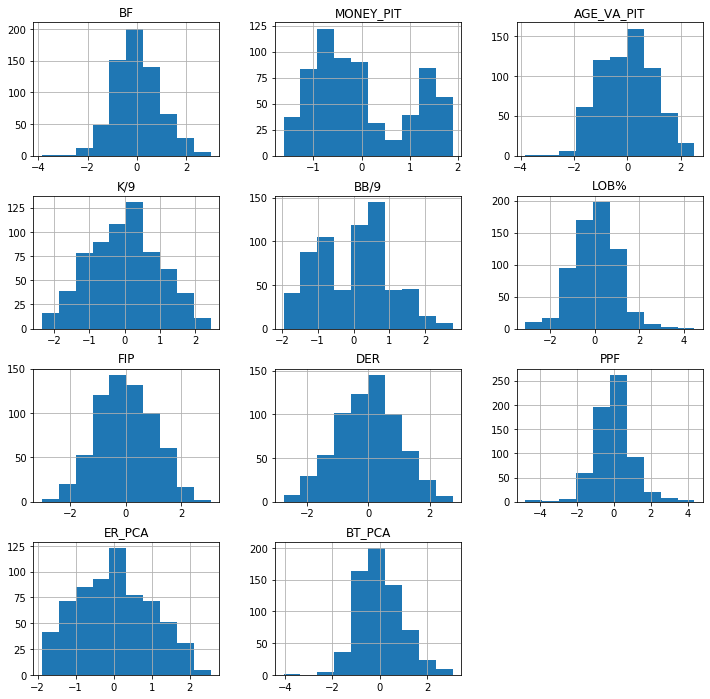

In [44]:
target = pitcher[pitcher["T_ID"] == "NC"].dropna().ERA[20:].reset_index(drop = True)

scaler = MinMaxScaler()
feature = pitcher[pitcher["T_ID"] == "NC"].dropna().drop(["GDAY_DS", "T_ID", "HEADER_NO", "H3", "IB",
                                                          "KK", "BB", "WLS_W", "INN2", "H2", "HR", "HP"], axis = "columns").reset_index(drop = True)

pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["ERA", "R", "ER", "RA/9", "ERA_WEIGHTED", "WHIP", "ERC"]])
feature["ER_PCA"] = res
feature = feature.drop(["ERA", "R", "ER", "RA/9", "ERA_WEIGHTED", "WHIP", "ERC"], axis = "columns")

pca = PCA(n_components = 1)
res = pca.fit_transform(feature[["PA", "AB", "HIT"]])
feature["BT_PCA"] = res
feature = feature.drop(["PA", "AB", "HIT"], axis = "columns")

feature = pd.DataFrame(scaler.fit_transform(feature), columns = feature.columns)

feature = pd.DataFrame(power_transform(feature, method = "yeo-johnson"), columns = feature.columns, index = feature.index.values)
feature = feature.loc[0:len(target)-1]
feature.hist(figsize = (12, 12))

In [45]:
feature.skew()

BF            0.137853
MONEY_PIT     0.478533
AGE_VA_PIT   -0.041178
K/9           0.032828
BB/9          0.039808
LOB%          0.105592
FIP           0.035622
DER          -0.048475
PPF          -0.064255
ER_PCA        0.066596
BT_PCA        0.342663
dtype: float64

In [46]:
feature.describe()

,BF,MONEY_PIT,AGE_VA_PIT,K/9,BB/9,LOB%,FIP,DER,PPF,ER_PCA,BT_PCA
count,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000
mean,0.000641,-0.001329,-0.007528,-0.015750,-0.001808,0.012955,0.002497,-0.009858,0.001636,0.003531,0.004648
std,0.938972,0.992796,0.988878,0.986753,0.995852,0.982927,0.997200,0.999433,1.007475,1.003857,0.930137
min,-3.860799,-1.618435,-3.817961,-2.347119,-1.951251,-3.104708,-3.015202,-2.772731,-4.781277,-1.892867,-4.053588
25%,-0.658501,-0.800501,-0.774971,-0.760618,-0.553950,-0.651251,-0.722584,-0.700623,-0.631764,-0.800855,-0.651966
50%,0.022898,-0.280198,0.044458,0.010056,-0.016623,0.021779,-0.011805,0.025952,0.065162,-0.015090,-0.135193
75%,0.587539,1.056612,0.697701,0.653120,0.646805,0.678153,0.706536,0.664048,0.570811,0.742916,0.633039
max,3.004614,1.892368,2.512778,2.439109,2.763455,4.466274,3.067166,2.751451,4.358628,2.551520,3.066330


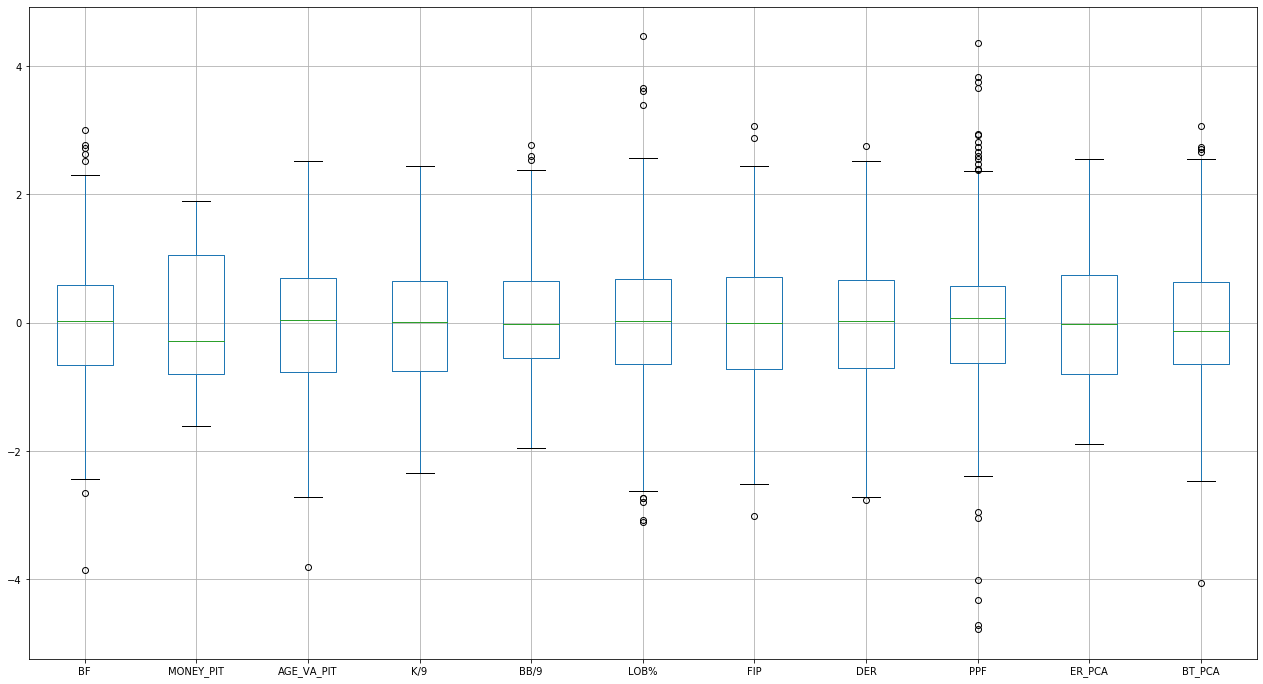

In [47]:
feature.boxplot(figsize = (22, 12))

In [48]:
feature.corr(method = "pearson")

,BF,MONEY_PIT,AGE_VA_PIT,K/9,BB/9,LOB%,FIP,DER,PPF,ER_PCA,BT_PCA
BF,1.000000,-0.168337,-0.136910,0.410567,0.526236,-0.167058,0.344781,-0.357142,-0.026757,0.512846,0.780907
MONEY_PIT,-0.168337,1.000000,0.722657,-0.053420,-0.257355,-0.009342,-0.227325,0.109972,-0.044279,-0.215884,-0.119511
AGE_VA_PIT,-0.136910,0.722657,1.000000,-0.037801,-0.239616,0.011803,-0.154149,0.093546,-0.059495,-0.162765,-0.044733
K/9,0.410567,-0.053420,-0.037801,1.000000,0.157881,-0.084204,-0.113712,-0.274116,-0.032890,0.076846,0.268070
BB/9,0.526236,-0.257355,-0.239616,0.157881,1.000000,-0.081352,0.470197,-0.127952,-0.024170,0.383465,0.251576
LOB%,-0.167058,-0.009342,0.011803,-0.084204,-0.081352,1.000000,-0.048185,0.187437,0.008173,-0.452693,-0.219968
FIP,0.344781,-0.227325,-0.154149,-0.113712,0.470197,-0.048185,1.000000,-0.086628,-0.051503,0.694151,0.383502
DER,-0.357142,0.109972,0.093546,-0.274116,-0.127952,0.187437,-0.086628,1.000000,0.007181,-0.484106,-0.536245
PPF,-0.026757,-0.044279,-0.059495,-0.032890,-0.024170,0.008173,-0.051503,0.007181,1.000000,-0.031760,-0.012318
ER_PCA,0.512846,-0.215884,-0.162765,0.076846,0.383465,-0.452693,0.694151,-0.484106,-0.031760,1.000000,0.680178


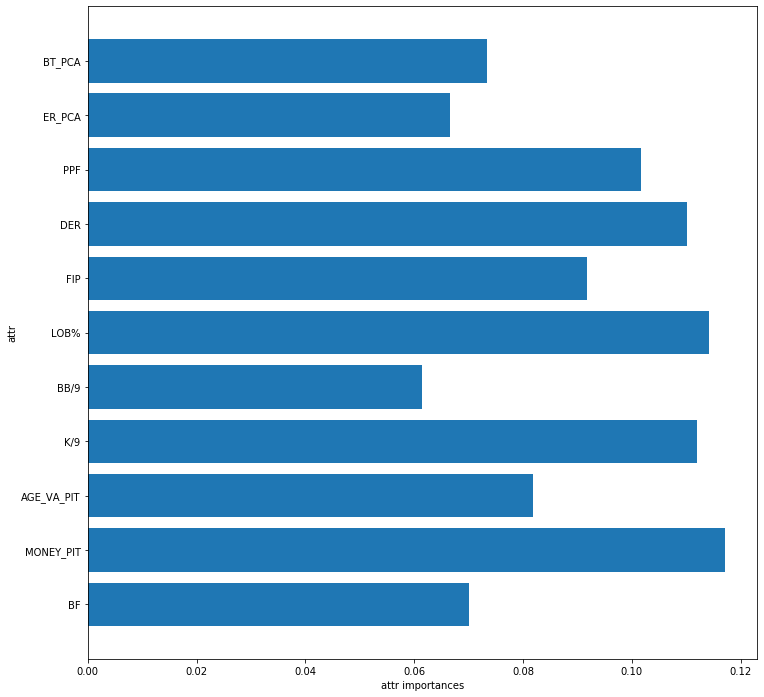

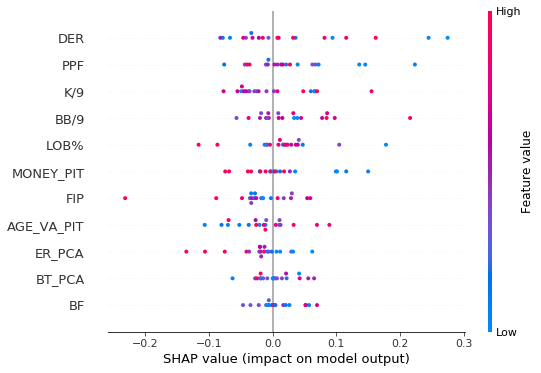

In [49]:
# Find Feature - GBRT
trainFeature = feature.loc[0:feature.shape[0]-20]
trainTarget = target.loc[0:feature.shape[0]-20]

testFeature = feature.loc[feature.shape[0]-20:].reset_index(drop = True)
testTarget = target[feature.shape[0]-20:].reset_index(drop = True)

tree = GradientBoostingRegressor(max_depth = 5,learning_rate = 0.1, n_estimators = 500, subsample = 0.8)
tree.fit(trainFeature, trainTarget)

tree.score(testFeature, testTarget)


n_features = trainFeature.shape[1]

plt.figure(figsize = (12, 12))
plt.barh(range(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), testFeature.columns)
plt.xlabel("attr importances")
plt.ylabel("attr")
plt.ylim(-1, n_features)
plt.show()

explainer = shap.TreeExplainer(tree, trainFeature)
shap_values = explainer.shap_values(testFeature, check_additivity = False)
shap.summary_plot(shap_values, testFeature)


In [50]:
# Find Feature - GBRT

result = tree.predict(testFeature)
result = result.reshape(testTarget.shape[0])

result.mean()

0.5512960582719907

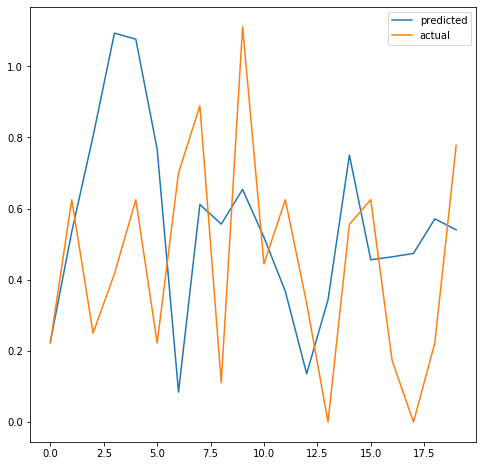

In [51]:

plt.figure(figsize = (8, 8))
plt.plot(result, label = "predicted")
plt.plot(testTarget, label = "actual")
plt.legend()
